# Prediction Delivery Time

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
import datetime as dt
import datetime 
import pytz
from dateutil import tz
from dateutil import parser



## EDA

Loading data

In [152]:
df_ebay = pd.read_csv('../data/raw/ebayShort.csv', nrows=700000 ,index_col=0)

### Explore Data


As the data is too big, we first working in the shortcut of the total data with 3000000 rows.

In [153]:
# Look at the first 5 row

df_ebay.head(5)

,b2c_c2c,seller_id,declared_handling_days,acceptance_scan_timestamp,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,item_zip,buyer_zip,category_id,item_price,quantity,payment_datetime,delivery_date,weight,weight_units,package_size,record_number
0,B2C,25454,3.0,2019-03-26 15:11:00.000-07:00,0,0.0,3,5,97219,49040,13,27.95,1,2019-03-24 03:56:49.000-07:00,2019-03-29,5,1,LETTER,1
1,C2C,6727381,2.0,2018-06-02 12:53:00.000-07:00,0,3.0,3,5,11415-3528,62521,0,20.50,1,2018-06-01 13:43:54.000-07:00,2018-06-05,0,1,PACKAGE_THICK_ENVELOPE,2
2,B2C,18507,1.0,2019-01-07 16:22:00.000-05:00,0,4.5,3,5,27292,53010,1,19.90,1,2019-01-06 00:02:00.000-05:00,2019-01-10,9,1,PACKAGE_THICK_ENVELOPE,3
3,B2C,4677,1.0,2018-12-17 16:56:00.000-08:00,0,0.0,3,5,90703,80022,1,35.50,1,2018-12-16 10:28:28.000-08:00,2018-12-21,8,1,PACKAGE_THICK_ENVELOPE,4
4,B2C,4677,1.0,2018-07-27 16:48:00.000-07:00,0,0.0,3,5,90703,55070,1,25.00,1,2018-07-26 18:20:02.000-07:00,2018-07-30,3,1,PACKAGE_THICK_ENVELOPE,5


In [154]:
df_ebay10= df_ebay.head(10)

In [155]:
#Look at 5 random row
df_ebay.sample(5)

,b2c_c2c,seller_id,declared_handling_days,acceptance_scan_timestamp,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,item_zip,buyer_zip,category_id,item_price,quantity,payment_datetime,delivery_date,weight,weight_units,package_size,record_number
528040,B2C,14151,10.0,2019-09-10 10:51:00.000-04:00,3,0.0,2,8,07940,37082,18,3.99,1,2019-09-08 08:15:16.000-04:00,2019-09-16,0,1,PACKAGE_THICK_ENVELOPE,528041
85816,B2C,13003,1.0,2019-07-30 14:53:00.000-04:00,0,0.0,3,5,17545,62959,13,25.99,2,2019-07-30 10:42:19.000-04:00,2019-08-02,3,1,PACKAGE_THICK_ENVELOPE,85817
529096,B2C,25692,2.0,2018-04-03 14:41:00.000-07:00,0,0.0,3,5,91403,38118,0,4.99,1,2018-03-30 20:16:37.000-07:00,2018-04-09,4,1,PACKAGE_THICK_ENVELOPE,529097
610663,B2C,8112,1.0,2019-01-14 10:46:00.000-08:00,0,0.0,3,5,94010,34238,0,14.88,1,2019-01-13 16:49:24.000-08:00,2019-01-18,0,1,NONE,610664
5290,B2C,18676,1.0,2018-06-05 16:41:00.000-05:00,3,3.7,2,8,53207,37331,14,5.00,1,2018-06-04 17:42:42.000-05:00,2018-06-09,32,1,PACKAGE_THICK_ENVELOPE,5291


In [156]:
#check the shape of the dataset
print(f'There are {df_ebay.shape[0]} columns and {df_ebay.shape[1]} rows')

There are 700000 columns and 19 rows


In [157]:
# Get a quick overview of dataset variables
df_ebay.dtypes

b2c_c2c                       object
seller_id                      int64
declared_handling_days       float64
acceptance_scan_timestamp     object
shipment_method_id             int64
shipping_fee                 float64
carrier_min_estimate           int64
carrier_max_estimate           int64
item_zip                      object
buyer_zip                     object
category_id                    int64
item_price                   float64
quantity                       int64
payment_datetime              object
delivery_date                 object
weight                         int64
weight_units                   int64
package_size                  object
record_number                  int64
dtype: object

Show the columns which is not numeric

In [158]:
# 5 rows showing only 'object' columns
df_ebay.select_dtypes('object').head()

,b2c_c2c,acceptance_scan_timestamp,item_zip,buyer_zip,payment_datetime,delivery_date,package_size
0,B2C,2019-03-26 15:11:00.000-07:00,97219,49040,2019-03-24 03:56:49.000-07:00,2019-03-29,LETTER
1,C2C,2018-06-02 12:53:00.000-07:00,11415-3528,62521,2018-06-01 13:43:54.000-07:00,2018-06-05,PACKAGE_THICK_ENVELOPE
2,B2C,2019-01-07 16:22:00.000-05:00,27292,53010,2019-01-06 00:02:00.000-05:00,2019-01-10,PACKAGE_THICK_ENVELOPE
3,B2C,2018-12-17 16:56:00.000-08:00,90703,80022,2018-12-16 10:28:28.000-08:00,2018-12-21,PACKAGE_THICK_ENVELOPE
4,B2C,2018-07-27 16:48:00.000-07:00,90703,55070,2018-07-26 18:20:02.000-07:00,2018-07-30,PACKAGE_THICK_ENVELOPE


### Data cleanding

First let do some common checking in the dataset.
 -  Null value
 -  Duplicate row

#### Check null and duplicate

In [159]:
# checking duplicate rows
df_ebay.duplicated().any()

False

There are no duplicate row in the database

In [160]:
#Checking null
df_ebay.isna().sum()

b2c_c2c                          0
seller_id                        0
declared_handling_days       33068
acceptance_scan_timestamp        0
shipment_method_id               0
shipping_fee                     0
carrier_min_estimate             0
carrier_max_estimate             0
item_zip                         0
buyer_zip                        0
category_id                      0
item_price                       0
quantity                         0
payment_datetime                 0
delivery_date                    0
weight                           0
weight_units                     0
package_size                     0
record_number                    0
dtype: int64

There are missing values in the `declared_handling_day` column

In [161]:
df_null=df_ebay[df_ebay.isna().any(axis=1)]
df_null.head()


,b2c_c2c,seller_id,declared_handling_days,acceptance_scan_timestamp,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,item_zip,buyer_zip,category_id,item_price,quantity,payment_datetime,delivery_date,weight,weight_units,package_size,record_number
111,B2C,1369,NaN,2018-01-19 12:20:00.000-05:00,0,0.00,3,5,32703,32042,5,5.80,1,2018-01-18 20:50:28.000-05:00,2018-01-26,3,1,PACKAGE_THICK_ENVELOPE,112
190,B2C,15812,NaN,2018-10-31 15:00:00.000-07:00,0,1.95,3,5,49938-2038,55418,12,2.95,1,2018-10-31 09:38:02.000-07:00,2018-11-02,2,1,PACKAGE_THICK_ENVELOPE,191
243,B2C,19122,NaN,2018-11-27 21:34:00.000-08:00,0,0.00,3,5,90014,72202,8,14.00,1,2018-11-23 13:32:25.000-08:00,2018-11-30,3,1,PACKAGE_THICK_ENVELOPE,244
300,C2C,982206,NaN,2018-11-20 22:14:00.000-05:00,0,3.25,3,5,19114,01001,0,8.00,1,2018-11-17 15:46:03.000-05:00,2018-11-23,0,1,PACKAGE_THICK_ENVELOPE,301
348,B2C,15830,NaN,2018-01-19 23:11:31.000-08:00,0,0.00,3,5,19124-2342,33050,5,5.32,1,2018-01-18 15:37:56.000-08:00,2018-01-23,0,1,NONE,349


We are going to fill the NaN value for `declared_handling_days` column by find the average of `declared_handling_days` from the same seller_id

In [162]:
#get all the data without nan value
df_no_nan= df_ebay[df_ebay.notna().all(axis=1)]
df_no_nan.head()

,b2c_c2c,seller_id,declared_handling_days,acceptance_scan_timestamp,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,item_zip,buyer_zip,category_id,item_price,quantity,payment_datetime,delivery_date,weight,weight_units,package_size,record_number
0,B2C,25454,3.0,2019-03-26 15:11:00.000-07:00,0,0.0,3,5,97219,49040,13,27.95,1,2019-03-24 03:56:49.000-07:00,2019-03-29,5,1,LETTER,1
1,C2C,6727381,2.0,2018-06-02 12:53:00.000-07:00,0,3.0,3,5,11415-3528,62521,0,20.50,1,2018-06-01 13:43:54.000-07:00,2018-06-05,0,1,PACKAGE_THICK_ENVELOPE,2
2,B2C,18507,1.0,2019-01-07 16:22:00.000-05:00,0,4.5,3,5,27292,53010,1,19.90,1,2019-01-06 00:02:00.000-05:00,2019-01-10,9,1,PACKAGE_THICK_ENVELOPE,3
3,B2C,4677,1.0,2018-12-17 16:56:00.000-08:00,0,0.0,3,5,90703,80022,1,35.50,1,2018-12-16 10:28:28.000-08:00,2018-12-21,8,1,PACKAGE_THICK_ENVELOPE,4
4,B2C,4677,1.0,2018-07-27 16:48:00.000-07:00,0,0.0,3,5,90703,55070,1,25.00,1,2018-07-26 18:20:02.000-07:00,2018-07-30,3,1,PACKAGE_THICK_ENVELOPE,5


In [163]:
#Mean of not nan
handling_mean= df_no_nan['declared_handling_days'].mean()
handling_mean

1.624269040921713

In [164]:
#Get the average for each seller_id
handling_day_mean_by_id=df_no_nan.groupby('seller_id').agg({'declared_handling_days':'mean'})

In [165]:
handling_days= df_ebay['declared_handling_days']
seller_id= df_ebay['seller_id']

In [166]:
handling_days_list=[]
for index, day in enumerate(handling_days):
    if np.isnan(day):
        seller= seller_id[index]
        if seller in handling_day_mean_by_id.index:
            handling_days_list.append(round(handling_day_mean_by_id[handling_day_mean_by_id.index==seller].values[0][0]))
        else:
            handling_days_list.append(round(handling_mean))
    else:
        handling_days_list.append(day)
df_ebay['declared_handling_days']= handling_days_list

In [167]:
df_ebay['declared_handling_days'].value_counts()

1.0     375546
2.0     139140
3.0     115698
0.0      48461
5.0      10705
4.0       5866
10.0      2921
15.0       629
30.0       520
20.0       406
6.0         40
8.0         22
7.0         16
40.0         7
9.0          5
11.0         4
16.0         4
12.0         4
19.0         2
14.0         2
13.0         1
22.0         1
Name: declared_handling_days, dtype: int64

#### Checking is there any unsusal value in columns.

In [168]:
#check is there any row in carrier_max_estimate and carrier_min_estimate have the unsual value
df_ebay[(df_ebay['carrier_max_estimate']<=0 ) | (df_ebay['carrier_min_estimate']<=0)]

,b2c_c2c,seller_id,declared_handling_days,acceptance_scan_timestamp,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,item_zip,buyer_zip,category_id,item_price,quantity,payment_datetime,delivery_date,weight,weight_units,package_size,record_number
19357,C2C,708260,2.0,2018-09-19 11:16:00.000-04:00,12,65.00,-1,-1,45504,01412000,3,61.00,1,2018-09-17 22:31:41.000-04:00,2018-10-08,48,1,PACKAGE_THICK_ENVELOPE,19358
19975,B2C,908,1.0,2019-01-04 12:13:00.000-05:00,12,12.00,-1,-1,03104,28232,2,22.44,1,2019-01-03 10:28:28.000-05:00,2019-01-31,0,1,LETTER,19976
27005,B2C,269,0.0,2018-08-20 13:48:00.000-07:00,12,1.70,-1,-1,93535-4990,L1T 3L7,4,2.20,1,2018-08-16 21:31:07.000-07:00,2018-08-29,2,1,PACKAGE_THICK_ENVELOPE,27006
34165,C2C,173517,2.0,2019-10-08 20:54:00.000-04:00,15,0.00,0,1,32064,12570,3,15.00,1,2019-10-07 02:34:18.000-04:00,2019-10-10,0,1,PACKAGE_THICK_ENVELOPE,34166
38042,B2C,102172,1.0,2018-01-29 14:25:00.000-06:00,12,0.95,-1,-1,53538,7570090,4,8.00,1,2018-01-28 13:21:39.000-06:00,2018-02-15,0,1,NONE,38043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653218,B2C,43670,1.0,2018-08-30 15:41:00.000-04:00,12,10.25,-1,-1,48867,P0M1L0,3,10.95,1,2018-08-30 01:46:53.000-04:00,2018-09-04,2,1,PACKAGE_THICK_ENVELOPE,653219
688603,C2C,522826,3.0,2018-03-08 10:11:00.000-06:00,12,16.00,-1,-1,73533,v1y9s8,4,75.00,1,2018-02-15 00:23:33.000-06:00,2018-03-15,16,1,PACKAGE_THICK_ENVELOPE,688604
690049,C2C,58572,2.0,2018-06-12 18:18:00.000-07:00,15,6.99,0,1,92119,28025,0,2.25,1,2018-06-11 15:57:29.000-07:00,2018-06-14,11,1,PACKAGE_THICK_ENVELOPE,690050
698650,B2C,11331,1.0,2018-04-13 19:42:00.000-04:00,15,0.00,0,1,11223,80517,0,24.99,1,2018-04-12 10:40:07.000-04:00,2018-04-16,16,1,PACKAGE_THICK_ENVELOPE,698651


Seem like there are some rows with the value of `carrier_max_estimate` and `carrier_min_estimate` is -1. We are going to spend more investigate on it

In [169]:
df= df_ebay[(df_ebay['carrier_max_estimate']<0 ) | (df_ebay['carrier_min_estimate']<0)]
print(df.shape)
df

(48, 19)


,b2c_c2c,seller_id,declared_handling_days,acceptance_scan_timestamp,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,item_zip,buyer_zip,category_id,item_price,quantity,payment_datetime,delivery_date,weight,weight_units,package_size,record_number
19357,C2C,708260,2.0,2018-09-19 11:16:00.000-04:00,12,65.00,-1,-1,45504,01412000,3,61.00,1,2018-09-17 22:31:41.000-04:00,2018-10-08,48,1,PACKAGE_THICK_ENVELOPE,19358
19975,B2C,908,1.0,2019-01-04 12:13:00.000-05:00,12,12.00,-1,-1,03104,28232,2,22.44,1,2019-01-03 10:28:28.000-05:00,2019-01-31,0,1,LETTER,19976
27005,B2C,269,0.0,2018-08-20 13:48:00.000-07:00,12,1.70,-1,-1,93535-4990,L1T 3L7,4,2.20,1,2018-08-16 21:31:07.000-07:00,2018-08-29,2,1,PACKAGE_THICK_ENVELOPE,27006
38042,B2C,102172,1.0,2018-01-29 14:25:00.000-06:00,12,0.95,-1,-1,53538,7570090,4,8.00,1,2018-01-28 13:21:39.000-06:00,2018-02-15,0,1,NONE,38043
42391,B2C,102172,1.0,2019-01-22 15:59:00.000-06:00,12,0.00,-1,-1,53538,7570090,4,10.55,1,2019-01-20 14:22:22.000-06:00,2019-01-30,0,1,NONE,42392
63216,B2C,1762594,2.0,2018-05-18 11:16:00.000-07:00,12,0.00,-1,-1,94124,80099,30,105.00,1,2018-05-16 12:55:36.000-07:00,2018-05-22,16,1,PACKAGE_THICK_ENVELOPE,63217
66574,B2C,40345,4.0,2018-11-27 18:38:00.000-05:00,12,10.00,-1,-1,48038,B3H 2T1,11,39.99,1,2018-11-27 08:51:13.000-05:00,2018-12-10,3,1,PACKAGE_THICK_ENVELOPE,66575
78072,B2C,66159,3.0,2018-09-13 11:25:00.000-06:00,12,23.50,-1,-1,79968,154-0012,6,116.50,1,2018-09-12 17:44:51.000-06:00,2018-09-21,16,1,PACKAGE_THICK_ENVELOPE,78073
78140,B2C,5197,1.0,2018-09-24 20:33:00.000-04:00,12,25.00,-1,-1,07307,8241587,18,9.99,1,2018-09-22 15:44:17.000-04:00,2018-10-20,0,1,PACKAGE_THICK_ENVELOPE,78141
98005,B2C,23064,1.0,2018-06-05 15:06:00.000-04:00,12,4.49,-1,-1,18045,K9J2P6,6,5.49,1,2018-06-04 08:30:13.000-04:00,2018-06-13,4,1,PACKAGE_THICK_ENVELOPE,98006


As we can see all the records have `carrier_max_estimate` and `carrier_min_estimate` = -1 is belong to the shipment method 12. Let check with the `shipment_method_id`=12 is there any other value for the `carrier_max_estimate` and `carrier_min_estimate`

In [170]:
df_ebay[df_ebay['shipment_method_id']==12][['carrier_max_estimate', 'carrier_min_estimate']].value_counts()

carrier_max_estimate  carrier_min_estimate
-1                    -1                      48
dtype: int64

So we can see that all the record with the `shipment_method_id`=12 will have the `carrier_max_estimate`and `carrier_min_estimate` =-1. The solution is we will replace those negative value by the mean value of 'carrier_max_estimate' and 'carrier_min_estimate'

In [171]:
# Max estimate mean
max_mean= df_ebay[df_ebay['shipment_method_id'] != 12]['carrier_max_estimate'].mean()

print(f'Mean value of carrier_max_estimate is : {max_mean}')

Mean value of carrier_max_estimate is : 5.464621859784671


Replace the `carrier_max_estimate` value in the row with `shipment_method_id`=12 by mean value of `carrier_max_estimate`

In [172]:
df_ebay['carrier_max_estimate']= np.where(df_ebay['shipment_method_id']==12, max_mean, df_ebay['carrier_max_estimate'])

In [173]:
#check
df_ebay[df_ebay['shipment_method_id']==12]['carrier_max_estimate']

19357     5.464622
19975     5.464622
27005     5.464622
38042     5.464622
42391     5.464622
63216     5.464622
66574     5.464622
78072     5.464622
78140     5.464622
98005     5.464622
108180    5.464622
110504    5.464622
110595    5.464622
115429    5.464622
130938    5.464622
143509    5.464622
157655    5.464622
158372    5.464622
172621    5.464622
201116    5.464622
202001    5.464622
213520    5.464622
251681    5.464622
258726    5.464622
279042    5.464622
305681    5.464622
306640    5.464622
317172    5.464622
340164    5.464622
357539    5.464622
378755    5.464622
407727    5.464622
413336    5.464622
434985    5.464622
448678    5.464622
487137    5.464622
489431    5.464622
490509    5.464622
501222    5.464622
513683    5.464622
531245    5.464622
535245    5.464622
583647    5.464622
596404    5.464622
619339    5.464622
653218    5.464622
688603    5.464622
698981    5.464622
Name: carrier_max_estimate, dtype: float64

In [174]:
#Min estimate mean

min_mean= df_ebay[df_ebay['shipment_method_id']!=12]['carrier_min_estimate'].mean()
print(f'Mean value of carrier_min_estimate is: {min_mean}')

Mean value of carrier_min_estimate is: 2.622162662582577


Replace the `carrier_min_estimate` value in the row with `shipment_method_id`=12 by mean value of `carrier_min_estimate`

In [175]:
df_ebay['carrier_min_estimate']= np.where(df_ebay['shipment_method_id']==12, min_mean, df_ebay['carrier_min_estimate'])

In [176]:
#Check
df_ebay[df_ebay['shipment_method_id']==12]['carrier_min_estimate']

19357     2.622163
19975     2.622163
27005     2.622163
38042     2.622163
42391     2.622163
63216     2.622163
66574     2.622163
78072     2.622163
78140     2.622163
98005     2.622163
108180    2.622163
110504    2.622163
110595    2.622163
115429    2.622163
130938    2.622163
143509    2.622163
157655    2.622163
158372    2.622163
172621    2.622163
201116    2.622163
202001    2.622163
213520    2.622163
251681    2.622163
258726    2.622163
279042    2.622163
305681    2.622163
306640    2.622163
317172    2.622163
340164    2.622163
357539    2.622163
378755    2.622163
407727    2.622163
413336    2.622163
434985    2.622163
448678    2.622163
487137    2.622163
489431    2.622163
490509    2.622163
501222    2.622163
513683    2.622163
531245    2.622163
535245    2.622163
583647    2.622163
596404    2.622163
619339    2.622163
653218    2.622163
688603    2.622163
698981    2.622163
Name: carrier_min_estimate, dtype: float64

#### Convert the `acceptance_scan_timestamp` and `payment_datetime` 


Working with `acceptance_scan_timestamp` and `payment_datetime`. convert all in to buyer timezone

In [177]:
#Recall these 2 columns
df_ebay[['acceptance_scan_timestamp', 'payment_datetime']]

,acceptance_scan_timestamp,payment_datetime
0,2019-03-26 15:11:00.000-07:00,2019-03-24 03:56:49.000-07:00
1,2018-06-02 12:53:00.000-07:00,2018-06-01 13:43:54.000-07:00
2,2019-01-07 16:22:00.000-05:00,2019-01-06 00:02:00.000-05:00
3,2018-12-17 16:56:00.000-08:00,2018-12-16 10:28:28.000-08:00
4,2018-07-27 16:48:00.000-07:00,2018-07-26 18:20:02.000-07:00
...,...,...
699995,2018-01-20 13:59:00.000-06:00,2018-01-19 13:57:56.000-06:00
699996,2018-02-01 11:14:00.000-07:00,2018-02-01 09:37:52.000-07:00
699997,2018-01-09 09:55:00.000-05:00,2018-01-08 17:15:56.000-05:00
699998,2018-01-17 00:42:00.000-05:00,2018-01-12 12:07:23.000-05:00


In [178]:
accept_date= df_ebay['acceptance_scan_timestamp']
pay_date= df_ebay['payment_datetime']
delivery_date= df_ebay['delivery_date']

In [179]:
#Date convert function
def convert_date_format(date_list):
    output_format = "%Y-%m-%d"
    dates=[]
    # input_date= datetime.strftime(date[0], input_format)
    for day in date_list:    
        # Parse the original timestamp into a datetime object
        dt = parser.parse(day)

        # Extract the original timezone offset from the timestamp
        original_timezone_offset = dt.strftime("%z")

        # Create a custom time zone with the original offset
        day = tz.tzoffset("Custom", datetime.timedelta(hours=int(original_timezone_offset[:3]), minutes=int(original_timezone_offset[3:])))

        # Convert the timezone to the desired timezone (US/Eastern)
        us_timezone = tz.gettz("US/Eastern")
        converted_dt = dt.replace(tzinfo=day).astimezone(us_timezone)

        # Check if the hour is greater than 11
        if converted_dt.hour > 11:
            # Add one day to the converted datetime
            converted_dt += datetime.timedelta(days=1)

        # Remove the hour and timezone
        converted_dt = converted_dt.replace(hour=0, minute=0, second=0, microsecond=0)

        # Format the converted datetime object into the desired string format
        converted_timestamp = converted_dt.strftime("%Y-%m-%d")
        # put in dates list
        dates.append(converted_timestamp)
    return dates

In [180]:
#convert
df_ebay['acceptance_scan_timestamp']= convert_date_format(accept_date)
df_ebay['payment_datetime']= convert_date_format(pay_date)

In [181]:
#Santity check
df_ebay['acceptance_scan_timestamp']

0         2019-03-27
1         2018-06-03
2         2019-01-08
3         2018-12-18
4         2018-07-28
             ...    
699995    2018-01-21
699996    2018-02-02
699997    2018-01-09
699998    2018-01-17
699999    2018-02-06
Name: acceptance_scan_timestamp, Length: 700000, dtype: object

In [182]:
#Santity check
df_ebay['payment_datetime']

0         2019-03-24
1         2018-06-02
2         2019-01-06
3         2018-12-17
4         2018-07-27
             ...    
699995    2018-01-20
699996    2018-02-01
699997    2018-01-09
699998    2018-01-13
699999    2018-02-06
Name: payment_datetime, Length: 700000, dtype: object

In [183]:
#Conver delivery_date to datetime
df_ebay['delivery_date'] = pd.to_datetime(df_ebay['delivery_date'])

Check the table data after cleaning


In [184]:
df_ebay.head()

,b2c_c2c,seller_id,declared_handling_days,acceptance_scan_timestamp,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,item_zip,buyer_zip,category_id,item_price,quantity,payment_datetime,delivery_date,weight,weight_units,package_size,record_number
0,B2C,25454,3.0,2019-03-27,0,0.0,3.0,5.0,97219,49040,13,27.95,1,2019-03-24,2019-03-29,5,1,LETTER,1
1,C2C,6727381,2.0,2018-06-03,0,3.0,3.0,5.0,11415-3528,62521,0,20.50,1,2018-06-02,2018-06-05,0,1,PACKAGE_THICK_ENVELOPE,2
2,B2C,18507,1.0,2019-01-08,0,4.5,3.0,5.0,27292,53010,1,19.90,1,2019-01-06,2019-01-10,9,1,PACKAGE_THICK_ENVELOPE,3
3,B2C,4677,1.0,2018-12-18,0,0.0,3.0,5.0,90703,80022,1,35.50,1,2018-12-17,2018-12-21,8,1,PACKAGE_THICK_ENVELOPE,4
4,B2C,4677,1.0,2018-07-28,0,0.0,3.0,5.0,90703,55070,1,25.00,1,2018-07-27,2018-07-30,3,1,PACKAGE_THICK_ENVELOPE,5


### Data Visualization

Let see the percent of the kind of customer B2C(Business to Consumer) and C2C(Consumer to Consumer)

In [185]:
df_ebay['b2c_c2c'].value_counts()

B2C    495539
C2C    204461
Name: b2c_c2c, dtype: int64

In [186]:
plt.figure(figsize=(16, 12))
fig= px.pie(df_ebay, values= df_ebay['b2c_c2c'].value_counts(), names=df_ebay['b2c_c2c'].unique(), title='Contribution of C2C and B2C')
fig.show()

<Figure size 1600x1200 with 0 Axes>

Seem like most of the seller is the business which take about 70% of the total amount of sale in the online selling platform. Consumer to consumer takes about 30.3% of the total amount, which is not a small amount, that we can see that there are more and more people start using the online platform to sell their product.

Let see overal how the seller declared the amount of time they need to proceesing order to make it ready to ship for customer 

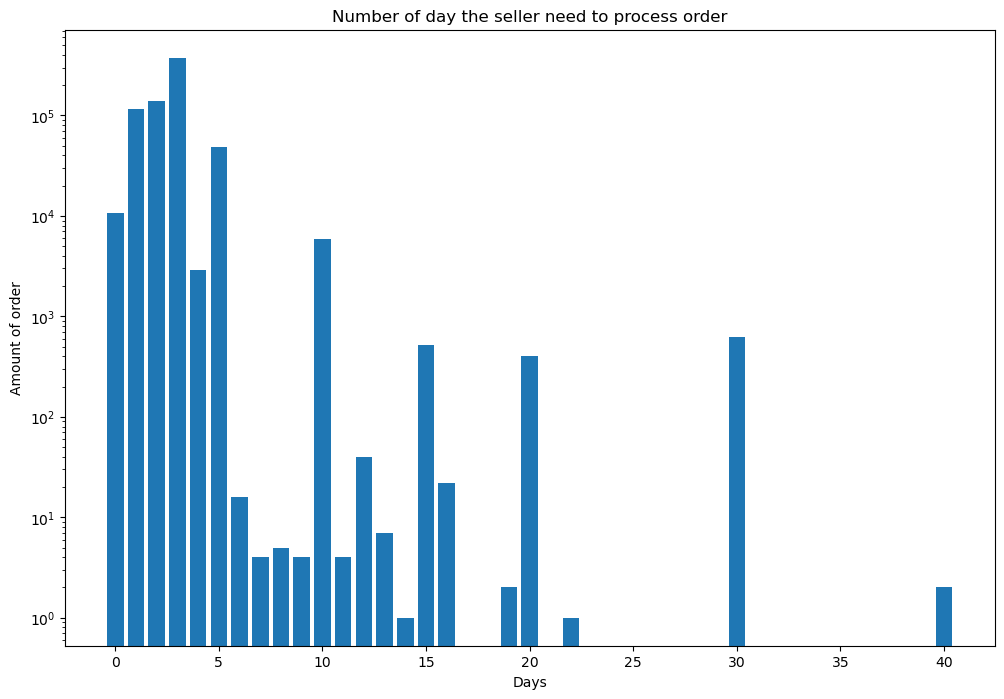

In [187]:
# fig= px.bar(df_ebay, x= 'declared_handling_days', y= df_ebay['declared_handling_days'].values)
# fig.show()

plt.figure(figsize=(12, 8))
plt.bar(df_ebay['declared_handling_days'].unique(), df_ebay['declared_handling_days'].value_counts())
plt.xlabel('Days')
plt.ylabel('Amount of order')
plt.yscale('log')
plt.title('Number of day the seller need to process order')
plt.show()


Most of the order has the estimate processing day very fast, about 0 day to 3 days need.

How many order was packed in each type of package size

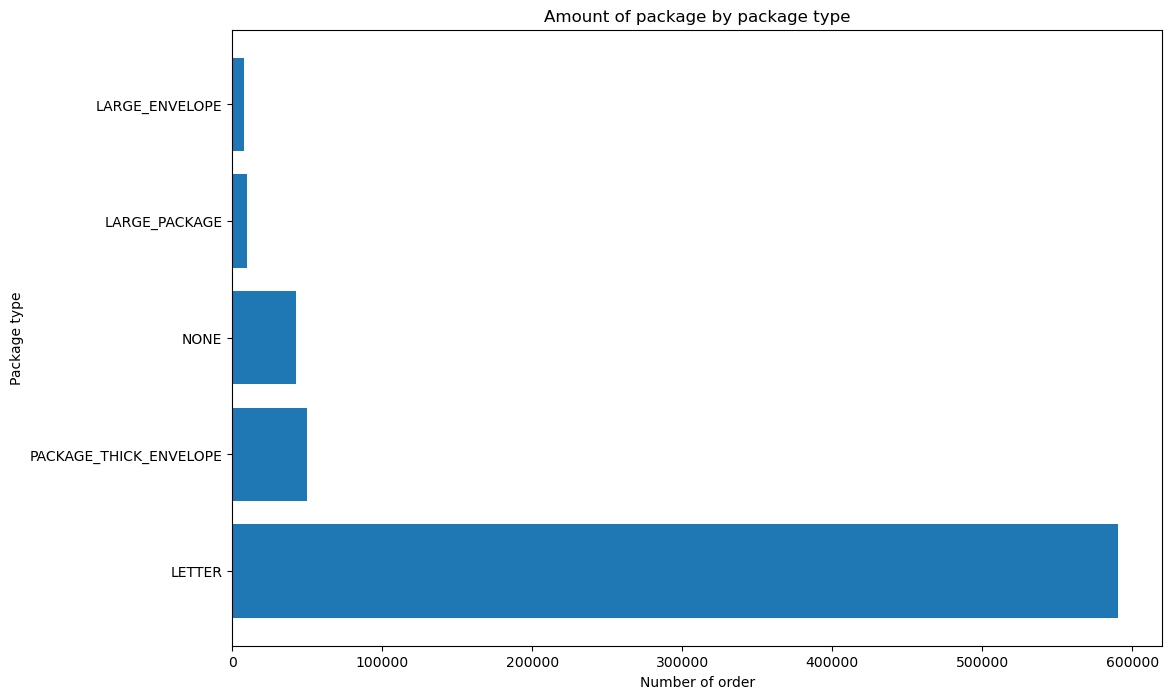

In [188]:
plt.figure(figsize=(12, 8))
plt.barh(df_ebay['package_size'].unique(), df_ebay['package_size'].value_counts())
plt.title("Amount of package by package type")
plt.xlabel('Number of order')
plt.ylabel('Package type')
plt.show()

Seem like most of the order is in small size and can be packed in `LETTER` size

number of order by month

In [189]:
d= pd.to_datetime(df_ebay['payment_datetime'])

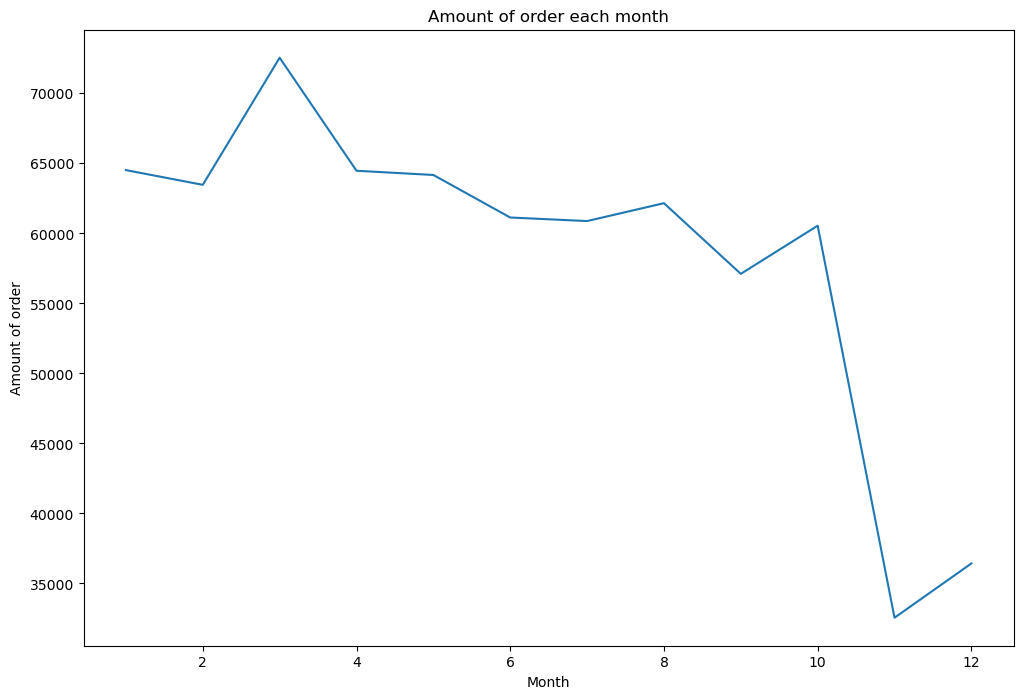

In [190]:
d= pd.to_datetime(df_ebay['payment_datetime'])
d= d.dt.month.value_counts().sort_index()
plt.figure(figsize=(12, 8))
sns.lineplot(d)
plt.title("Amount of order each month")
plt.xlabel("Month")
plt.ylabel("Amount of order")
plt.show()

## Feature Engineering

Let check out the distributions, we are going to check over all the column in the dataset

In [191]:
# Re call the dataset 
df_ebay.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700000 entries, 0 to 699999
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   b2c_c2c                    700000 non-null  object        
 1   seller_id                  700000 non-null  int64         
 2   declared_handling_days     700000 non-null  float64       
 3   acceptance_scan_timestamp  700000 non-null  object        
 4   shipment_method_id         700000 non-null  int64         
 5   shipping_fee               700000 non-null  float64       
 6   carrier_min_estimate       700000 non-null  float64       
 7   carrier_max_estimate       700000 non-null  float64       
 8   item_zip                   700000 non-null  object        
 9   buyer_zip                  700000 non-null  object        
 10  category_id                700000 non-null  int64         
 11  item_price                 700000 non-null  float64 

#### b2c_c2c

In [192]:
#checking the b2c_c2c column
df_ebay['b2c_c2c'].value_counts()

B2C    495539
C2C    204461
Name: b2c_c2c, dtype: int64

Convert `b2c_c2c` column to binary

In [193]:
df_ebay['b2c_c2c']= np.where(df_ebay['b2c_c2c']=='B2C', 1, 0)

In [194]:
#Santity check
df_ebay.head()

,b2c_c2c,seller_id,declared_handling_days,acceptance_scan_timestamp,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,item_zip,buyer_zip,category_id,item_price,quantity,payment_datetime,delivery_date,weight,weight_units,package_size,record_number
0,1,25454,3.0,2019-03-27,0,0.0,3.0,5.0,97219,49040,13,27.95,1,2019-03-24,2019-03-29,5,1,LETTER,1
1,0,6727381,2.0,2018-06-03,0,3.0,3.0,5.0,11415-3528,62521,0,20.50,1,2018-06-02,2018-06-05,0,1,PACKAGE_THICK_ENVELOPE,2
2,1,18507,1.0,2019-01-08,0,4.5,3.0,5.0,27292,53010,1,19.90,1,2019-01-06,2019-01-10,9,1,PACKAGE_THICK_ENVELOPE,3
3,1,4677,1.0,2018-12-18,0,0.0,3.0,5.0,90703,80022,1,35.50,1,2018-12-17,2018-12-21,8,1,PACKAGE_THICK_ENVELOPE,4
4,1,4677,1.0,2018-07-28,0,0.0,3.0,5.0,90703,55070,1,25.00,1,2018-07-27,2018-07-30,3,1,PACKAGE_THICK_ENVELOPE,5


#### Weigth and Weight_units

There is 2 `weight_units` is 1 and 2. Let say 1 - 'lbs' and 2 - 'kg'. We are going to convert all the weight units to lb.

In [195]:
#check the record has weigtht unit =2 to able to compare
df_ebay[df_ebay['weight_units']==2].head()

,b2c_c2c,seller_id,declared_handling_days,acceptance_scan_timestamp,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,item_zip,buyer_zip,category_id,item_price,quantity,payment_datetime,delivery_date,weight,weight_units,package_size,record_number
115821,1,46815,1.0,2018-01-29,0,0.0,3.0,5.0,35503,30605,1,6.89,2,2018-01-29,2018-01-31,113,2,LARGE_ENVELOPE,115822


In [196]:
#Convert them in to lb.
df_ebay['weight'] = np.where(df_ebay['weight_units']==1, df_ebay['weight'], df_ebay['weight']*2.20462 )

check the record with `weight_units`=2 to see if the `weight` column is changed

In [197]:
df_ebay[df_ebay['weight_units']==2]

,b2c_c2c,seller_id,declared_handling_days,acceptance_scan_timestamp,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,item_zip,buyer_zip,category_id,item_price,quantity,payment_datetime,delivery_date,weight,weight_units,package_size,record_number
115821,1,46815,1.0,2018-01-29,0,0.0,3.0,5.0,35503,30605,1,6.89,2,2018-01-29,2018-01-31,249.12206,2,LARGE_ENVELOPE,115822


All the `weight` with the `weight_units` = 2 are convert to the **lb** unit. So now we do not need to keep the weight column since all the weight is in the **lb**. Therefore, we are going to drop the `weight_units` column.

In [198]:
df_ebay.drop(columns='weight_units', axis=1, inplace=True)

In [199]:
#check it
df_ebay.head()

,b2c_c2c,seller_id,declared_handling_days,acceptance_scan_timestamp,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,item_zip,buyer_zip,category_id,item_price,quantity,payment_datetime,delivery_date,weight,package_size,record_number
0,1,25454,3.0,2019-03-27,0,0.0,3.0,5.0,97219,49040,13,27.95,1,2019-03-24,2019-03-29,5.0,LETTER,1
1,0,6727381,2.0,2018-06-03,0,3.0,3.0,5.0,11415-3528,62521,0,20.50,1,2018-06-02,2018-06-05,0.0,PACKAGE_THICK_ENVELOPE,2
2,1,18507,1.0,2019-01-08,0,4.5,3.0,5.0,27292,53010,1,19.90,1,2019-01-06,2019-01-10,9.0,PACKAGE_THICK_ENVELOPE,3
3,1,4677,1.0,2018-12-18,0,0.0,3.0,5.0,90703,80022,1,35.50,1,2018-12-17,2018-12-21,8.0,PACKAGE_THICK_ENVELOPE,4
4,1,4677,1.0,2018-07-28,0,0.0,3.0,5.0,90703,55070,1,25.00,1,2018-07-27,2018-07-30,3.0,PACKAGE_THICK_ENVELOPE,5


The `weigth_units` column has been dropped. 

#### Package_size

Check the `package_size` column

In [200]:
#How many type of package 
df_ebay['package_size'].value_counts()

PACKAGE_THICK_ENVELOPE    590466
NONE                       49586
LETTER                     42243
LARGE_ENVELOPE              9672
LARGE_PACKAGE               8033
Name: package_size, dtype: int64

There are 5 type of package. so we can use the ordinal encoding to tranfer this column to numeric instead of category column. `'NONE': 0, 'LETTER': 1, 'LARGE_ENVELOPE': 2, 'LARGE_PACKAGE': 3, 'PACKAGE_THICK_ENVELOPE': 4`

In [201]:
oe_package= OrdinalEncoder(categories=[['NONE', 'LETTER', 'LARGE_ENVELOPE',
                                         'LARGE_PACKAGE', 'PACKAGE_THICK_ENVELOPE']])
df_ebay['package_size']=oe_package.fit_transform(pd.DataFrame(df_ebay['package_size'])) 

In [202]:
df_ebay['package_size'].value_counts()

4.0    590466
0.0     49586
1.0     42243
2.0      9672
3.0      8033
Name: package_size, dtype: int64

In [203]:
# Check it
df_ebay.head()

,b2c_c2c,seller_id,declared_handling_days,acceptance_scan_timestamp,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,item_zip,buyer_zip,category_id,item_price,quantity,payment_datetime,delivery_date,weight,package_size,record_number
0,1,25454,3.0,2019-03-27,0,0.0,3.0,5.0,97219,49040,13,27.95,1,2019-03-24,2019-03-29,5.0,1.0,1
1,0,6727381,2.0,2018-06-03,0,3.0,3.0,5.0,11415-3528,62521,0,20.50,1,2018-06-02,2018-06-05,0.0,4.0,2
2,1,18507,1.0,2019-01-08,0,4.5,3.0,5.0,27292,53010,1,19.90,1,2019-01-06,2019-01-10,9.0,4.0,3
3,1,4677,1.0,2018-12-18,0,0.0,3.0,5.0,90703,80022,1,35.50,1,2018-12-17,2018-12-21,8.0,4.0,4
4,1,4677,1.0,2018-07-28,0,0.0,3.0,5.0,90703,55070,1,25.00,1,2018-07-27,2018-07-30,3.0,4.0,5


#### Item_zip and buyer_zip

Next we are going to calculate the distance between the buyer and the seller buy using there zip code in the `item_zip` and `buyer_zip` columns.

In [204]:
#check any null value in these columns.
print(df_ebay['item_zip'].isna().any())
print(df_ebay['buyer_zip'].isna().any())

False
False


In [205]:
item_zip= df_ebay['item_zip']
buyer_zip= df_ebay['buyer_zip']

In [ ]:
import mpu
from uszipcode import SearchEngine
# from pathlib_mate.pathlib2 import Path
# import uszipcode.search as search

def get_distance(item_zip, buyer_zip):
    """
    We are going to use the package mpu and uszipcode to imporve the speed of calculating the distance between buyer and seller by using zip code. 
    These 2 packages make the speed of calculation much faster compare with using the geopy package
    """
    if item_zip is not None and buyer_zip is not None:
        search_location = SearchEngine()
        item_location = search_location.by_zipcode(item_zip[0:5])
        buyer_location =search_location.by_zipcode(buyer_zip[0:5])
        if item_location is None or buyer_location is None:
            return None
        else:
            lat1 =item_location.lat
            long1 =item_location.lng
            lat2 =buyer_location.lat
            long2 =buyer_location.lng
            distance = mpu.haversine_distance((lat1,long1),(lat2,long2)) 
            if lat1 is None or lat2 is None or long1 is None or long2 is None:
                return None
            return [distance, lat1, long1, lat2, long2]
    else:
        return None



def add_zip_distance_column(item_zip, buyer_zip):
    item_zip_str = item_zip.apply(lambda x: str(x))
    buyer_zip_str = buyer_zip.apply(lambda x: str(x))

    zips = pd.concat([item_zip_str, buyer_zip_str], axis=1)

    zips['distance'] = zips.apply(lambda x: get_distance(x.item_zip, x.buyer_zip), axis=1)
    
    return zips['distance']

In [207]:
distance = add_zip_distance_column(item_zip, buyer_zip)

In [208]:
distance_lat_lon= distance

In [209]:
dis = np.array([])
seller_lat = np.array([])
seller_lon = np.array([])
buyer_lat = np.array([])
buyer_lon = np.array([])

for i in range(len(distance_lat_lon)):
    
        if distance_lat_lon[i] is None:
            dis = np.append(dis, None)
            seller_lat = np.append(seller_lat, None)
            seller_lon = np.append(seller_lon, None)
            buyer_lat = np.append(buyer_lat, None)
            buyer_lon = np.append(buyer_lon, None)
        else:
            dis = np.append(dis, distance_lat_lon[i][0])
            seller_lat = np.append(seller_lat, distance_lat_lon[i][1])
            seller_lon = np.append(seller_lon, distance_lat_lon[i][2])
            buyer_lat = np.append(buyer_lat, distance_lat_lon[i][3])
            buyer_lon = np.append(buyer_lon, distance_lat_lon[i][4])


KeyboardInterrupt: 

In [210]:
len(dis)

372786

Add the value of the distance in to the data frame

In [139]:
df_ebay['distance']= dis
df_ebay['seller_lat']= seller_lat
df_ebay['seller_lon']= seller_lon
df_ebay['buyer_lat']= buyer_lat
df_ebay['buyer_lon']= buyer_lon
df_ebay.head(10)

,b2c_c2c,seller_id,declared_handling_days,acceptance_scan_timestamp,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,item_zip,buyer_zip,...,weight,package_size,record_number,handling_date,shipping_date,total_time,pay_year,pay_month,pay_date,distance
0,1,25454,3,2019-03-27,0,0,3,5,97219,49040,...,5,1,1,3,2,5,2019,3,24,"[3001.839178989944, 45.45, -122.69, 41.95, -85..."
1,0,6727381,2,2018-06-03,0,3,3,5,11415-3528,62521,...,0,4,2,1,2,3,2018,6,2,"[1282.9080171786184, 40.71, -73.83, 39.85, -88..."
2,1,18507,1,2019-01-08,0,4,3,5,27292,53010,...,9,4,3,2,2,4,2019,1,6,"[1104.4441680982743, 35.8, -80.25, 43.59, -88.28]"
3,1,4677,1,2018-12-18,0,0,3,5,90703,80022,...,8,4,4,1,3,4,2018,12,17,"[1353.3900033822747, 33.86, -118.05, 39.88, -1..."
4,1,4677,1,2018-07-28,0,0,3,5,90703,55070,...,3,4,5,1,2,3,2018,7,27,"[2456.330752334089, 33.86, -118.05, 45.39, -93..."
5,1,10514,1,2019-04-20,0,0,3,5,43215,77063,...,1,4,6,1,2,3,2019,4,19,"[1608.340905965056, 39.97, -83.01, 29.74, -95.52]"
6,1,104,1,2019-02-09,0,0,3,5,91304,60565,...,0,4,7,0,2,2,2019,2,9,"[2781.5279390595124, 34.22, -118.59, 41.73, -8..."
7,1,340356,1,2018-04-24,0,3,3,5,49735,29379,...,1,4,8,1,1,2,2018,4,23,"[1174.2702460445782, 45.02, -84.67, 34.72, -81..."
8,1,113915,5,2019-10-12,3,0,2,8,43606,32958,...,0,0,9,1,3,4,2019,10,11,"[1568.8677999315253, 41.66, -83.58, 27.78, -80..."
9,1,130301,1,2019-08-10,1,0,2,5,35117,84776,...,112,4,10,1,2,3,2019,8,9,"[2311.0154499869755, 33.67, -86.89, 37.64, -11..."


Take a look at th data  after change

In [88]:
df_ebay.head(10)

,b2c_c2c,seller_id,declared_handling_days,acceptance_scan_timestamp,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,item_zip,buyer_zip,category_id,item_price,quantity,payment_datetime,delivery_date,weight,package_size,record_number,distance
0,1,25454,3.0,2019-03-27,0,0.00,3.0,5.0,97219,49040,13,27.95,1,2019-03-24,2019-03-29,5.0,1.0,1,3001.839179
1,0,6727381,2.0,2018-06-03,0,3.00,3.0,5.0,11415-3528,62521,0,20.50,1,2018-06-02,2018-06-05,0.0,4.0,2,1282.908017
2,1,18507,1.0,2019-01-08,0,4.50,3.0,5.0,27292,53010,1,19.90,1,2019-01-06,2019-01-10,9.0,4.0,3,1104.444168
3,1,4677,1.0,2018-12-18,0,0.00,3.0,5.0,90703,80022,1,35.50,1,2018-12-17,2018-12-21,8.0,4.0,4,1353.390003
4,1,4677,1.0,2018-07-28,0,0.00,3.0,5.0,90703,55070,1,25.00,1,2018-07-27,2018-07-30,3.0,4.0,5,2456.330752
5,1,10514,1.0,2019-04-20,0,0.00,3.0,5.0,43215,77063,3,10.39,1,2019-04-19,2019-04-22,1.0,4.0,6,1608.340906
6,1,104,1.0,2019-02-09,0,0.00,3.0,5.0,91304,60565,11,5.70,1,2019-02-09,2019-02-11,0.0,4.0,7,2781.527939
7,1,340356,1.0,2018-04-24,0,2.95,3.0,5.0,49735,29379,1,6.00,1,2018-04-23,2018-04-25,1.0,4.0,8,1174.270246
8,1,113915,5.0,2019-10-12,3,0.00,2.0,8.0,43606,32958,18,5.55,1,2019-10-11,2019-10-15,0.0,0.0,9,1568.867800
9,1,130301,1.0,2019-08-10,1,0.00,2.0,5.0,35117,84776,13,59.98,1,2019-08-09,2019-08-12,112.0,4.0,10,2311.015450


#### Creater new column using `acceptance_scan_timestamp`, `payment_datetime` and `delivery_date`

Now we see that most of the column is in the good shape. But the model cannot run with the datetime type of variable. So we are going to create some 2 new column base on the datetime column. 
-   **handling_date** = `acceptance_scan_timestamp` - `payment_dateime`
-   **shipping_date** = `delivery_date` - `acceptance_scan_timestamp`
-   **total_time** = `delivery_date` - `payment_dateime`

First, we convert all 3 columns to datetime value

In [89]:
df_ebay['acceptance_scan_timestamp']= pd.to_datetime(df_ebay['acceptance_scan_timestamp'])
df_ebay['payment_datetime']= pd.to_datetime(df_ebay['payment_datetime'])
df_ebay['delivery_date']= pd.to_datetime(df_ebay['delivery_date'])

In [90]:
#calulate date function
def date_calculate(day1, day2):
    number_of_day=[]
    date_list= day2- day1
    for day in date_list:
        date= day.days
        number_of_day.append(date)
    return number_of_day


In [91]:
#calulate handling_date
handling_date= date_calculate(df_ebay['payment_datetime'], df_ebay['acceptance_scan_timestamp'])

#calculate shipping_date
shipping_date= date_calculate(df_ebay['acceptance_scan_timestamp'], df_ebay['delivery_date'])

#calculate totlatime

total_time= date_calculate(df_ebay['payment_datetime'], df_ebay['delivery_date'])


Create `handling_date` and `shipping_date` as new columns in data frame and add the value for it

In [92]:
df_ebay['handling_date']= handling_date
df_ebay['shipping_date']= shipping_date
df_ebay['total_time']= total_time

In [93]:
#check data frame
df_ebay.sample(10)

,b2c_c2c,seller_id,declared_handling_days,acceptance_scan_timestamp,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,item_zip,buyer_zip,...,quantity,payment_datetime,delivery_date,weight,package_size,record_number,distance,handling_date,shipping_date,total_time
149467,1,1070,1.0,2019-02-19,0,0.00,3.0,5.0,91203,72450,...,1,2019-02-18,2019-02-20,6.0,4.0,149468,2524.817521,1,1,2
401041,1,9374,1.0,2018-08-03,0,0.00,3.0,5.0,18403,04478,...,1,2018-08-02,2018-08-06,16.0,4.0,401042,657.297910,1,3,4
437924,1,19887,1.0,2018-10-30,0,0.00,3.0,5.0,02740,36693,...,1,2018-10-27,2018-10-31,0.0,1.0,437925,1965.206779,3,1,4
233524,1,81,1.0,2019-06-25,0,0.00,3.0,5.0,11213,21212,...,1,2019-06-23,2019-06-26,4.0,4.0,233525,269.406004,2,1,3
222504,1,2264,0.0,2019-02-17,0,4.99,3.0,5.0,83843,44429,...,1,2019-02-16,2019-02-19,6.0,4.0,222505,2918.504228,1,2,3
336612,1,10390,0.0,2019-09-10,0,0.00,3.0,5.0,96002,10306,...,1,2019-09-08,2019-09-12,1.0,1.0,336613,4018.128767,2,2,4
320588,1,629,0.0,2018-12-05,0,0.00,3.0,5.0,44321,48341,...,1,2018-12-04,2018-12-07,0.0,4.0,320589,219.068036,1,2,3
573639,1,31968,1.0,2018-07-21,0,3.05,3.0,5.0,17301,80013,...,1,2018-07-20,2018-07-23,7.0,4.0,573640,2365.586408,1,2,3
950428,1,38370,1.0,2018-03-06,9,0.00,2.0,5.0,33160,90660,...,1,2018-03-04,2018-03-07,32.0,2.0,950429,3740.592639,2,1,3
189209,0,447715,2.0,2018-09-23,0,3.75,3.0,5.0,11779,47235,...,1,2018-09-21,2018-09-24,7.0,4.0,189210,1125.775682,2,1,3


#### Seprate the payment_datetime to year, mon, date column

In [94]:
df_ebay['pay_year']= df_ebay['payment_datetime'].dt.year
df_ebay['pay_month']= df_ebay['payment_datetime'].dt.month
df_ebay['pay_date']= df_ebay['payment_datetime'].dt.day


In [95]:
#Check table
df_ebay.head()

,b2c_c2c,seller_id,declared_handling_days,acceptance_scan_timestamp,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,item_zip,buyer_zip,...,weight,package_size,record_number,distance,handling_date,shipping_date,total_time,pay_year,pay_month,pay_date
0,1,25454,3.0,2019-03-27,0,0.0,3.0,5.0,97219,49040,...,5.0,1.0,1,3001.839179,3,2,5,2019,3,24
1,0,6727381,2.0,2018-06-03,0,3.0,3.0,5.0,11415-3528,62521,...,0.0,4.0,2,1282.908017,1,2,3,2018,6,2
2,1,18507,1.0,2019-01-08,0,4.5,3.0,5.0,27292,53010,...,9.0,4.0,3,1104.444168,2,2,4,2019,1,6
3,1,4677,1.0,2018-12-18,0,0.0,3.0,5.0,90703,80022,...,8.0,4.0,4,1353.390003,1,3,4,2018,12,17
4,1,4677,1.0,2018-07-28,0,0.0,3.0,5.0,90703,55070,...,3.0,4.0,5,2456.330752,1,2,3,2018,7,27


In [96]:
df_ebay.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 25 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   b2c_c2c                    1000000 non-null  int64         
 1   seller_id                  1000000 non-null  int64         
 2   declared_handling_days     1000000 non-null  float64       
 3   acceptance_scan_timestamp  1000000 non-null  datetime64[ns]
 4   shipment_method_id         1000000 non-null  int64         
 5   shipping_fee               1000000 non-null  float64       
 6   carrier_min_estimate       1000000 non-null  float64       
 7   carrier_max_estimate       1000000 non-null  float64       
 8   item_zip                   1000000 non-null  object        
 9   buyer_zip                  1000000 non-null  object        
 10  category_id                1000000 non-null  int64         
 11  item_price                 1000000 non

In [97]:
df_ebay.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 25 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   b2c_c2c                    1000000 non-null  int64         
 1   seller_id                  1000000 non-null  int64         
 2   declared_handling_days     1000000 non-null  float64       
 3   acceptance_scan_timestamp  1000000 non-null  datetime64[ns]
 4   shipment_method_id         1000000 non-null  int64         
 5   shipping_fee               1000000 non-null  float64       
 6   carrier_min_estimate       1000000 non-null  float64       
 7   carrier_max_estimate       1000000 non-null  float64       
 8   item_zip                   1000000 non-null  object        
 9   buyer_zip                  1000000 non-null  object        
 10  category_id                1000000 non-null  int64         
 11  item_price                 1000000 non

We are going to convert all the float column in to interger.


#### Recheck the table and save data in new csv file


In [98]:
df_ebay.shape


(1000000, 25)

In [99]:
df_ebay.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 25 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   b2c_c2c                    1000000 non-null  int64         
 1   seller_id                  1000000 non-null  int64         
 2   declared_handling_days     1000000 non-null  float64       
 3   acceptance_scan_timestamp  1000000 non-null  datetime64[ns]
 4   shipment_method_id         1000000 non-null  int64         
 5   shipping_fee               1000000 non-null  float64       
 6   carrier_min_estimate       1000000 non-null  float64       
 7   carrier_max_estimate       1000000 non-null  float64       
 8   item_zip                   1000000 non-null  object        
 9   buyer_zip                  1000000 non-null  object        
 10  category_id                1000000 non-null  int64         
 11  item_price                 1000000 non

In [100]:
#convert all float column to interger
df_ebay[['declared_handling_days', 'shipping_fee','carrier_min_estimate', 'carrier_max_estimate', 'item_price', 'weight', 'package_size', 'distance']] =\
      round(df_ebay[['declared_handling_days', 'shipping_fee','carrier_min_estimate', 'carrier_max_estimate', 'item_price', 'weight', 'package_size', 'distance']])

In [101]:
#check null again
df_ebay.isna().sum()

b2c_c2c                          0
seller_id                        0
declared_handling_days           0
acceptance_scan_timestamp        0
shipment_method_id               0
shipping_fee                     0
carrier_min_estimate             0
carrier_max_estimate             0
item_zip                         0
buyer_zip                        0
category_id                      0
item_price                       0
quantity                         0
payment_datetime                 0
delivery_date                    0
weight                           0
package_size                     0
record_number                    0
distance                     11842
handling_date                    0
shipping_date                    0
total_time                       0
pay_year                         0
pay_month                        0
pay_date                         0
dtype: int64

We can see there are some value in the `distance` column is count as NA here. It could be because the Zipcode of the buyer or seller is not in the right format. We are going to drop all of row with NA in distance here since it is only 1257 rows over 95042 rows in total(around 1.3% the amount of data).

In [102]:
df_ebay= df_ebay.dropna()
df_ebay.isna().any().any()

False

In [103]:
df_ebay[['declared_handling_days', 'shipping_fee','carrier_min_estimate', 'carrier_max_estimate', 'item_price', 'weight', 'package_size', 'distance']] = \
df_ebay[['declared_handling_days', 'shipping_fee','carrier_min_estimate', 'carrier_max_estimate', 'item_price', 'weight', 'package_size', 'distance']] .astype(int)

In [104]:
df_ebay.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 988158 entries, 0 to 999999
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   b2c_c2c                    988158 non-null  int64         
 1   seller_id                  988158 non-null  int64         
 2   declared_handling_days     988158 non-null  int64         
 3   acceptance_scan_timestamp  988158 non-null  datetime64[ns]
 4   shipment_method_id         988158 non-null  int64         
 5   shipping_fee               988158 non-null  int64         
 6   carrier_min_estimate       988158 non-null  int64         
 7   carrier_max_estimate       988158 non-null  int64         
 8   item_zip                   988158 non-null  object        
 9   buyer_zip                  988158 non-null  object        
 10  category_id                988158 non-null  int64         
 11  item_price                 988158 non-null  int64   

Now we export the data to the new CSV then later on we only work with clean data

,b2c_c2c,seller_id,declared_handling_days,acceptance_scan_timestamp,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,item_zip,buyer_zip,...,weight,package_size,record_number,distance,handling_date,shipping_date,total_time,pay_year,pay_month,pay_date
0,1,25454,3,2019-03-27,0,0,3,5,97219,49040,...,5,1,1,3002,3,2,5,2019,3,24
1,0,6727381,2,2018-06-03,0,3,3,5,11415-3528,62521,...,0,4,2,1283,1,2,3,2018,6,2
2,1,18507,1,2019-01-08,0,4,3,5,27292,53010,...,9,4,3,1104,2,2,4,2019,1,6
3,1,4677,1,2018-12-18,0,0,3,5,90703,80022,...,8,4,4,1353,1,3,4,2018,12,17
4,1,4677,1,2018-07-28,0,0,3,5,90703,55070,...,3,4,5,2456,1,2,3,2018,7,27


In [412]:
df_ebay.to_csv('../data/cleaned/Ebay_cleaned.csv')